In [2]:
import site, os
try:
    print(site.getsitepackages())
except:
    print(os.path.dirname(site.__file__) + '/site-packages')

/Users/csaintje/Documents/Recherche/Python/Envs/scientific_3_5/bin/../lib/python3.5/site-packages


In [3]:
import numpy as np
import scipy.integrate as sci
import scipy.optimize as sco
import scipy.stats as scs
from sympy import Function, Derivative, var, simplify, collect, expand, factor, Matrix
from sympy.abc import x, y, z, t
from sympy import diff, hessian, exp, log, pi, sqrt, lambdify, ask, Q, assuming
import itertools as it
import matplotlib
%matplotlib inline
#print (matplotlib.rcsetup.interactive_bk)
#print (matplotlib.rcsetup.non_interactive_bk)
#print (matplotlib.rcsetup.all_backends)
print (matplotlib.get_backend())
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from joblib import Memory, Parallel, delayed, dump, load

module://ipykernel.pylab.backend_inline


In [10]:
import theano.tensor as T
import theano

Details for gaussian distribution as an exponential family

In [11]:
def lb2th(mu,sigma2):
    return mu / sigma2, 0.5 / sigma2

def lb2et(mu, sigma2):
    return mu, -(mu**2+sigma2)

def th2lb(th1,th2):
    return 0.5*th1/th2, 0.5 / th2

def th2et(th1,th2):
    return 0.5*th1/th2, 0.5*(-0.5*th1**2/th2 - 1) / th2

def et2lb(et1,et2):
    return et1, -(et1**2+et2)

def et2th(et1,et2):
    return - et1 /(et1**2 + et2), -0.5 /(et1**2 + et2)

def s_1(x):
    return x

def s_2(x):
    return -x*x

def F_1D(theta1,theta2):
    return 0.25*theta1*theta1/theta2 + 0.5*np.log(np.pi) - 0.5*np.log(theta2) 

def gradF_1_1D(theta_1,theta_2):
    return 0.5*theta_1/theta_2

def gradF_2_1D(theta_1, theta_2):
    temp_1 = 0.5 / theta_2
    temp_2 = temp_1 * theta_1
    return -1. * (temp_2 * temp_2 + temp_1)

def gradF_1_nD(theta_1,theta_2):
    return 0.5*np.dot(np.inv(theta_2), theta_1)

def gradF_2_nD(theta_1, theta_2):
    temp_1 = 0.5*np.inv(theta_2)
    temp_2 = np.dot(temp1,theta_1)
    return - np.outer(temp_2,temp_2) - temp_1

def gradG_1_1D(eta_1,eta_2):
    return eta1 / (-eta_1 * eta1 - eta2)

def gradG_2_1D(eta_1,eta_2):
    return 0.5  / (-eta_1 * eta1 - eta2)

def gradG_1_nD(eta_1,eta_2):
    return np.dot(np.inv(-np.outer(eta_1, eta1) - eta2), eta1)

def gradG_2_nD(eta_1,eta_2):
    return 0.5*np.inv(-np.outer(eta_1, eta1) - eta2)


Cas 1D - Data

In [12]:
seed = 13
np.random.seed(seed)
N, batch_size = 20000*4, 100
mu_true, sigma_true = 1, 2
sigma2_true = sigma_true**2
theta1_true, theta2_true = lb2th(mu_true, sigma2_true)
eta1_true, eta2_true = lb2et(mu_true, sigma2_true)
X = np.random.normal(mu_true,np.sqrt(sigma2_true), N)
replicate = 100
mu_0, sigma2_0 = 0, 5
a_0 = 1 
lb_init = [(mu, sigma2) for mu, sigma2 in 
           zip(np.random.normal(mu_0,np.sqrt(sigma2_0), replicate),
               scs.invgamma.rvs(a_0, size=replicate))]
th_init = [lb2th(mu, sigma2) for mu, sigma2 in lb_init]
et_init = [lb2et(mu, sigma2) for mu, sigma2 in lb_init]
#print(lb_init, th_init, et_init)
def batches(Y, bs):
    nb = np.int(np.ceil(len(Y) / bs))
    Yb = [Y[i * bs : (i+1) * bs] for i in range(nb)]
    def __temp(i):
        return Yb[i]
    return nb, Yb, __temp

Xt = X[: N//4]
Nt = len(Xt)
NtB, XtB, XtB_f = batches(Xt, batch_size)
Xv = X[N//4 : N//2]
Nv = len(Xv)
NvB, XvB, XvB_f = batches(Xv, batch_size)
Xtest = X[N//2:]

In [13]:
def ll(x, mu, sigma2):
    #assert(sigma2 > 0)
    return -(x - mu)**2 /(2 * sigma2) - np.log(np.sqrt(2 * sigma2 * np.pi)) 

def ll_theta(x, theta1, theta2):
    return s_1(x) * theta1 + s_2(x) * theta2 - F_1D(theta1, theta2)

def ll_eta(x, eta1, eta2):
    theta1 = - eta1 / (eta1*eta1 + eta2)
    theta2 = - 0.5  / (eta1*eta1 + eta2)
    return ll_theta(x, theta1, theta2)

def kl(mu_1, s_1, mu_2, s_2):
    if s_1 > 0 and s_2 > 0:
        val = 0.5*(np.log(s_2/s_1) + (s_1/s_2) + ((mu_1 - mu_2)**2 / s_2)  - 1)
    else:
        val = -1.
    return val
    
def ave_ll(mu, sigma2, chi):
    return np.nanmean(ll(x, mu, sigma2) for x in chi)
    
def C_N(mu, sigma2, chi):
    #assert(sigma2 > 0)
    return -ave_ll(mu, sigma2, chi)

np.testing.assert_allclose(ll(4, mu_true, sigma2_true),
                          ll_theta(4, theta1_true, theta2_true))
np.testing.assert_allclose(ll(4, mu_true, sigma2_true),
                          ll_eta(4, eta1_true, eta2_true))

# Calculs symboliques

## Autour de F

In [14]:
theta1, theta2 = var('theta1 theta2')
F =  factor((theta1*theta1/(2*theta2) + log(pi) + - log(theta2))/2)
print('------F--------')
print(F)
dF1 = diff(F, theta1)
dF2 = factor(diff(F, theta2))
print('------Grad F*--------')
print (dF1)
print (dF2)
print('----- Terms of hessian ---------')
dF11 = diff(dF1, theta1)
dF12 = diff(dF1, theta2)
dF21 = diff(dF2, theta1)
dF22 = diff(dF2, theta2)
print ('H1,1',dF11)
print ('H1,2',dF12)
print ('H2,1',dF21)
print ('H2,2',dF22)
print('---- Hessian F ----------')
J = simplify(factor(expand(hessian(F, [theta1, theta2]))))
print(J)

------F--------
(theta1**2 - 2*theta2*log(theta2) + 2*theta2*log(pi))/(4*theta2)
------Grad F*--------
theta1/(2*theta2)
-(theta1**2 + 2*theta2)/(4*theta2**2)
----- Terms of hessian ---------
H1,1 1/(2*theta2)
H1,2 -theta1/(2*theta2**2)
H2,1 -theta1/(2*theta2**2)
H2,2 -1/(2*theta2**2) + (theta1**2 + 2*theta2)/(2*theta2**3)
---- Hessian F ----------
Matrix([
[         1/(2*theta2),              -theta1/(2*theta2**2)],
[-theta1/(2*theta2**2), (theta1**2 + theta2)/(2*theta2**3)]])


## Autour de F*


In [161]:
eta1 = var('eta1', real = True)
eta2 = var('eta2', real = True, negative= True)
Fs =  factor(-(1 + log (pi) + log(2*(- eta1*eta1 - eta2))) / 2)
print('------F*--------')
print(Fs)
dFs1 = diff(Fs, eta1)
dFs2 = diff(Fs, eta2)
print('------Grad F*--------')
print (dFs1)
print (dFs2)
print('----- Terms of hessian---------')
dFs11 = diff(dFs1, eta1)
dFs12 = diff(dFs1, eta2)
dFs21 = diff(dFs2, eta1)
dFs22 = diff(dFs2, eta2)
print ('H1,1',dFs11)
print ('H1,2',dFs12)
print ('H2,1',dFs21)
print ('H2,2',dFs22)
print('----Hessian F*----------')
Js = simplify(factor(expand(hessian(Fs, [eta1, eta2]))))
print(Js)
print('---- conditionnnement----------')
print(Js.condition_number())
#eps = var('eps', real = True, positive = True)
#Ieps = Matrix(2,2,[eps, 0,0, eps])
#Jse = Js + Ieps
#print(Jse.condition_number())
#et1, et2 = lb2et(mus[166], sigma2s[170])
#print(Js.subs([(eta1, et1), (eta2, et2)]).condition_number().evalf())

------F*--------
-(log(-2*eta1**2 - 2*eta2) + 1 + log(pi))/2
------Grad F*--------
2*eta1/(-2*eta1**2 - 2*eta2)
1/(-2*eta1**2 - 2*eta2)
----- Terms of hessian---------
H1,1 8*eta1**2/(-2*eta1**2 - 2*eta2)**2 + 2/(-2*eta1**2 - 2*eta2)
H1,2 4*eta1/(-2*eta1**2 - 2*eta2)**2
H2,1 4*eta1/(-2*eta1**2 - 2*eta2)**2
H2,2 2/(-2*eta1**2 - 2*eta2)**2
----Hessian F*----------
Matrix([
[(eta1**2 - eta2)/(eta1**2 + eta2)**2,  eta1/(eta1**2 + eta2)**2],
[            eta1/(eta1**2 + eta2)**2, 1/(2*(eta1**2 + eta2)**2)]])
---- conditionnnement----------
Max(sqrt(-(eta1**2 + eta2)**2*(2*eta1**2 - 2*eta2 + 1)*sqrt(4*eta1**4 - 8*eta1**2*eta2 + 12*eta1**2 + 4*eta2**2 + 4*eta2 + 1)/(8*(eta1**12 + 6*eta1**10*eta2 + 15*eta1**8*eta2**2 + 20*eta1**6*eta2**3 + 15*eta1**4*eta2**4 + 6*eta1**2*eta2**5 + eta2**6)) + (4*eta1**4 - 8*eta1**2*eta2 + 8*eta1**2 + 4*eta2**2 + 1)/(8*(eta1**2 + eta2)**4)), sqrt((eta1**2 + eta2)**2*(2*eta1**2 - 2*eta2 + 1)*sqrt(4*eta1**4 - 8*eta1**2*eta2 + 12*eta1**2 + 4*eta2**2 + 4*eta2 + 1)/(

In [159]:
def cond_func (mu, s2):
    et1, et2 = lb2et(mu, s2)
    #print(et1, et2)
    expr = Js.subs([(eta1, et1), (eta2, et2)])
    expr = np.array(expr.tolist()).astype(np.float64)
    #print(expr)
    expr = np.linalg.cond(expr)
    #expr = expr.subs([(eta1, et1), (eta2, et2)])
    #expr = expr.subs([(eta1, et1), (eta2, et2), (eps, 1e-6)])
    return expr

#lambdify((eta1,eta2), Js.condition_number(), "numpy")
# Make 2D permutation list with K=0~10 and L=0~10:
mu_min, mu_max, s_min, s_max, n = -100, 100, 1e-6, 100, 201
mus = np.linspace(mu_min, mu_max, n)
sigma2s = np.linspace(s_min, s_max, n)
X, Y = np.meshgrid(mus, sigma2s)
Z = [[cond_func(mu, sigma2) for mu in mus] for sigma2 in sigma2s]
Z = np.array(Z)

/Users/csaintje/Documents/Recherche/Python/Envs/scientific_3_5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


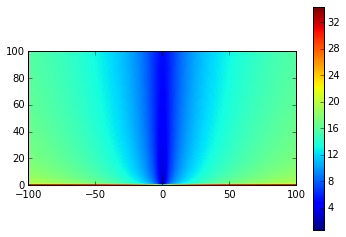

In [160]:
plt.imshow(np.log(1+Z), #, interpolation="bicubic",
           origin="lower", extent=[mu_min, mu_max, s_min, s_max])
#plt.contour(X, Y, Z, cmap='RdBu')
#plt.xticks(np.arange(-100,100,20))
#plt.yticks(np.arange(0,100,10))
#plt.ylabel(sigma2s)
plt.colorbar()
#print(np.log(1+Z[170]))
#print(np.log(1+cond_func(*lb2et(mus[166], sigma2s[170]))))
#print(cond_func(et1, et2))
#print(mus[166], sigma2s[170])
#print (*lb2et(mus[166], sigma2s[170]))

## Maj gradient stochastique dans H

In [77]:
x, alpha  = var('x alpha')
s1 = Function('s1')(x) # x
s2 = Function('s2')(x) #-x*x
expr1 = Matrix(2,1,[eta1, eta2])
expr2 = Matrix(2,1,[s1-eta1, s2-eta2])
update_rule = expr1 + alpha * Js * expr2
print('-------Update Rule-------')
print(update_rule[0])
print(update_rule[1])
print('-------Update Rule with x -------')
print(update_rule[0].subs(* [(s1, x), (s2, -x**2)]))
print(update_rule[1].subs([(s1, x), (s2, -x**2)]))
print('------- check -------')
temp1 = (eta1*(eta2 + x**2) + (eta1 - x)*(8*eta1**2 - 8*eta2)/8)/(eta1**2 + eta2)**2
temp2 = (eta1*(eta1 - x) + (1/2)*eta2 + (1/2)*x**2)/(eta1**2 + eta2)**2
versus = - Js * expr2
print(simplify(versus.subs([(s1, x), (s2, -x**2)])))
print(simplify(versus[0].subs([(s1, x), (s2, -x**2)]) - temp1))
print(simplify(versus[1].subs([(s1, x), (s2, -x**2)]) - temp2))

-------Update Rule-------
alpha*eta1*(-eta2 + s2(x))/(eta1**2 + eta2)**2 + alpha*(-eta1 + s1(x))*(eta1**2 - eta2)/(eta1**2 + eta2)**2 + eta1
alpha*eta1*(-eta1 + s1(x))/(eta1**2 + eta2)**2 + alpha*(-eta2 + s2(x))/(2*(eta1**2 + eta2)**2) + eta2
-------Update Rule with x -------
alpha*eta1*(-eta2 + s2(x))/(eta1**2 + eta2)**2 + alpha*(-eta1 + s1(x))*(eta1**2 - eta2)/(eta1**2 + eta2)**2 + eta1
alpha*eta1*(-eta1 + x)/(eta1**2 + eta2)**2 + alpha*(-eta2 - x**2)/(2*(eta1**2 + eta2)**2) + eta2
------- check -------
Matrix([
[(eta1*(eta2 + x**2) + (eta1 - x)*(eta1**2 - eta2))/(eta1**2 + eta2)**2],
[             (2*eta1*(eta1 - x) + eta2 + x**2)/(2*(eta1**2 + eta2)**2)]])
0
0


## Fisher Information Matrix
### Parametrisation (mu, sigma2)

In [6]:
from sympy.stats import E, Normal
x, mu = var('x mu')


sigma2 = var('sigma2', positive=True)
p = exp(- (x - mu)**2 / (2 * sigma2)) / sqrt(2 * sigma2 * pi)
score = simplify(Matrix(2,1,[diff(log(p),mu), diff(log(p),sigma2)]))
print('--- score ----')
print (simplify(score))
print('--- score * score.T ----')
outer = score * score.T
print (simplify(outer))
X = Normal('X', mu, sqrt(sigma2))
I = E(outer.subs([(x, X)]))
print('--- Fisher Information Matrix ----')
print(simplify(I))


--- score ----
Matrix([
[                     (-mu + x)/sigma2],
[(-sigma2 + (mu - x)**2)/(2*sigma2**2)]])
--- score * score.T ----
Matrix([
[                        (mu - x)**2/sigma2**2, (mu - x)*(sigma2 - (mu - x)**2)/(2*sigma2**3)],
[(mu - x)*(sigma2 - (mu - x)**2)/(2*sigma2**3),       (sigma2 - (mu - x)**2)**2/(4*sigma2**4)]])
--- Fisher Information Matrix ----
Matrix([
[1/sigma2,               0],
[       0, 1/(2*sigma2**2)]])


## Fisher Information Matrix
### Parametrisation (mu, sigma)

In [7]:
from sympy.stats import E, Normal
x, mu = var('x mu')
sigma = var('sigma', positive=True)
p = exp(- (x - mu)**2 / (2 * sigma**2)) / sqrt(2 * sigma**2 * pi)
score = simplify(Matrix(2,1,[diff(log(p),mu), diff(log(p),sigma)]))
print('--- score ----')
print (simplify(score))
print('--- score * score.T ----')
outer = score * score.T
print (simplify(outer))
X = Normal('X', mu, sigma)
I = E(outer.subs([(x, X)]))
print('--- Fisher Information Matrix ----')
print(simplify(I))


--- score ----
Matrix([
[                (-mu + x)/sigma**2],
[(-sigma**2 + (mu - x)**2)/sigma**3]])
--- score * score.T ----
Matrix([
[                      (mu - x)**2/sigma**4, (mu - x)*(sigma**2 - (mu - x)**2)/sigma**5],
[(mu - x)*(sigma**2 - (mu - x)**2)/sigma**5,       (sigma**2 - (mu - x)**2)**2/sigma**6]])
--- Fisher Information Matrix ----
Matrix([
[sigma**(-2),          0],
[          0, 2/sigma**2]])


In [17]:
t1, t2 = var('t1 t2')
et1 = t1 / (2*t2)
et2 = -t1**2/(4*t2**2) - 1 /(2*t2)
M = Matrix(2,2,[diff(et1,t1),diff(et1,t2), diff(et2,t1), diff(et2,t2)])
print(simplify(M.subs([(t1, mu/sigma2), (t2, 1/(2*sigma2))])))


Matrix([
[      sigma2,                -2*mu*sigma2],
[-2*mu*sigma2, 2*sigma2*(2*mu**2 + sigma2)]])


# Titterington

 ----- Gradient -------- 
Matrix([[Z1/w1 - Z4/(-w1 - w2 - w3 + 1)], [Z2/w2 - Z4/(-w1 - w2 - w3 + 1)], [Z3/w3 - Z4/(-w1 - w2 - w3 + 1)], [Z1*(s1(x) - Derivative(F1(t1), t1))], [Z2*(s2(x) - Derivative(F2(t2), t2))], [Z3*(s3(x) - Derivative(F3(t3), t3))], [Z4*(s4(x) - Derivative(F(t4), t4))]])
 ----- Hessienne -------- 
Matrix([[-Z1/w1**2 - Z4/(-w1 - w2 - w3 + 1)**2, -Z4/(-w1 - w2 - w3 + 1)**2, -Z4/(-w1 - w2 - w3 + 1)**2, 0, 0, 0, 0], [-Z4/(-w1 - w2 - w3 + 1)**2, -Z2/w2**2 - Z4/(-w1 - w2 - w3 + 1)**2, -Z4/(-w1 - w2 - w3 + 1)**2, 0, 0, 0, 0], [-Z4/(-w1 - w2 - w3 + 1)**2, -Z4/(-w1 - w2 - w3 + 1)**2, -Z3/w3**2 - Z4/(-w1 - w2 - w3 + 1)**2, 0, 0, 0, 0], [0, 0, 0, -Z1*Derivative(F1(t1), t1, t1), 0, 0, 0], [0, 0, 0, 0, -Z2*Derivative(F2(t2), t2, t2), 0, 0], [0, 0, 0, 0, 0, -Z3*Derivative(F3(t3), t3, t3), 0], [0, 0, 0, 0, 0, 0, -Z4*Derivative(F(t4), t4, t4)]])
 ----- Hessienne test -------- 
-Z4/(-w1 - w2 - w3 + 1)**2
 ----- MAJ -------- 
Matrix([
[-Z1/w1**2 - Z4/(-w1 - w2 - w3 + 1)**2,          

AttributeError: 'list' object has no attribute 'is_Integer'

In [19]:
from sympy import Function, Symbol, hessian, Matrix, Inverse, var, log, diff, simplify
t1, t2, t3, t4 = var('t1'), var('t2'), var('t3'), var('t4')
w1, w2, w3 = Symbol('w1'), Symbol('w2'), Symbol('w3')
F1, F2, F3, F4 = Function('F1')(t1), Function('F2')(t2), Function('F3')(t3), Function('F4')(t4)
x = var('x')
s1, s2, s3 = Function('s1')(x), Function('s2')(x), Function('s3')(x), Function('s4')(x)
z1, z2, z3, z4 = var('z1 z2 z3 z4')
z = Matrix(3, 1, [z1, z2, z3])
lw = Matrix(3, 1, [log(w1), log(w2), log(w3)])
F = Matrix(3, 1, [-F1, -F2, -F3])
T = Matrix(3, 1, [t1, t2, t3])
sxz = Matrix(6, 1, [z1, z1*s1, z2, z2*s2, z3, z3*s3])
tc = Matrix(6, 1, [log(w1)-F1,t1,log(w2)-F2,t2,log(1-w1-w2)-F3,t3])
logp = sxz.T * tc 
params = [w1, w2, t1, t2, t3]
G = Matrix([diff(logp, p) for p in params])
H = simplify(hessian(logp,params))
IH = Inverse(H)
print(' ----- Gradient -------- ')
print(G)
print(' ----- Hessienne -------- ')
print(H)
print(' ----- MAJ -------- ')
print(IH)
print(IH*G)
#H = np.array([[diff(g[m], p) for m in range(len(g))] for p in params])
#print (H)


 ----- Gradient -------- 
Matrix([[-z3/(-w1 - w2 + 1) + z1/w1], [-z3/(-w1 - w2 + 1) + z2/w2], [z1*s1(x) - z1*Derivative(F1(t1), t1)], [z2*s2(x) - z2*Derivative(F2(t2), t2)], [z3*s3(x) - z3*Derivative(F3(t3), t3)]])
 ----- Hessienne -------- 
Matrix([
[-z3/(w1 + w2 - 1)**2 - z1/w1**2,            -z3/(w1 + w2 - 1)**2,                              0,                              0,                              0],
[           -z3/(w1 + w2 - 1)**2, -z3/(w1 + w2 - 1)**2 - z2/w2**2,                              0,                              0,                              0],
[                              0,                               0, -z1*Derivative(F1(t1), t1, t1),                              0,                              0],
[                              0,                               0,                              0, -z2*Derivative(F2(t2), t2, t2),                              0],
[                              0,                               0,                           